# Setup

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LN

# Question 1

In [2]:
img = cv.imread('coins_1.jfif')
blur = cv.medianBlur(img, 5)
gray = cv.cvtColor(blur, cv.COLOR_BGR2GRAY)

# Hough circle transform
img_hough = img.copy()
row = img_hough.shape[0]
circles = cv.HoughCircles(gray, cv.HOUGH_GRADIENT, 1, row/8, param1 = 150, 
                         param2 = 25)

if circles is not None:
    circles = np.uint8(np.around(circles))
    for i in circles[0]:
        # draw the center of the circle
        center = (i[0], i[1])
        cv.circle(img_hough, center, 1, (100, 100, 100), 3)
        # draw the whole circle
        radius = i[2]
        cv.circle(img_hough, center, radius, (255, 0, 0), 2)

# Blob detection
img_blob = img.copy()

# parameter setting
params = cv.SimpleBlobDetector_Params()

# turn off the filter
params.minThreshold = 10
params.maxThreshold = 250
params.thresholdStep = 5
params.filterByColor = True
params.blobColor = 255
params.filterByArea = True
params.minArea = 20
params.filterByConvexity = False
params.filterByInertia = False

# detector
detector = cv.SimpleBlobDetector_create(params)
keypoints = detector.detect(gray)

# draw
im_keypoints = cv.drawKeypoints(img_blob, keypoints, np.array([]), (0, 0, 255), 
                               cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

cv.imshow('detect', np.hstack((img_hough, im_keypoints)))
cv.waitKey(0)
cv.destroyAllWindows()

* Hough transform: All coins are detected and wider edge is drawn on the edge of coins. The centre of the coins is also plotted.
* Blob detection: All coins are detected but some of the edges is not drawn on the edge of the coins. More configuration may need to be done on the blob detection in order to produce a results that are similar to the Hough transform.

# Question 2

* Determine the optimal k

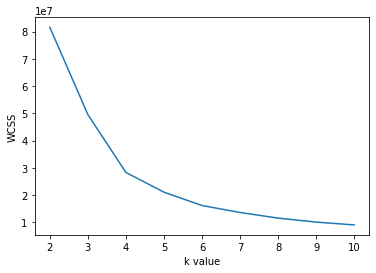

In [3]:
# read the image and convert to HSV
img = cv.imread('zebra.jfif')
img_copy = img.copy()
img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

# reshape the image
img_reshape = img_copy.reshape((-1, 3))
img_reshape = np.float32(img_reshape)

img_hsv_reshape = img_hsv.reshape((-1, 3))
img_hsv_reshape = np.float32(img_hsv_reshape)

# array for storing k value and ret
k_value = np.array([])
WCSS = np.array([])

# apply k-mean clustering on BGR image
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
attempts = 10
for k in range(2, 11):
    ret, label, center = cv.kmeans(img_reshape, k, None, criteria, attempts, 
                               cv.KMEANS_PP_CENTERS)
    k_value = np.append(k_value, k)
    WCSS = np.append(WCSS, ret)   
    
# plot the graph
plt.plot(k_value, WCSS)
plt.xlabel('k value'), plt.ylabel('WCSS')
plt.show()

Comment: The optimal k is 4. Because there is clear elbow at k = 4.

* Apply the clustering method on BGR and HSV

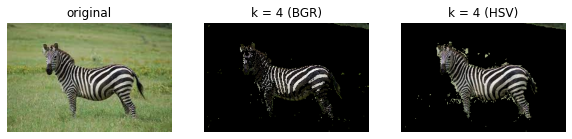

In [4]:
# Apply k-means clustering on BGR and HSV image with k = 4
K = 4
ret, label, center = cv.kmeans(img_reshape, K, None, criteria, attempts, 
                               cv.KMEANS_PP_CENTERS)
ret2, label2, center2 = cv.kmeans(img_hsv_reshape, K, None, criteria, 
                                  attempts, cv.KMEANS_PP_CENTERS)

# Convert the center to np.uint8
center = np.uint8(center)
res = center[label.flatten()]
result_img = res.reshape(img_copy.shape)

center2 = np.uint8(center2)
res2 = center2[label2.flatten()]
result_img_hsv = res2.reshape(img_hsv.shape)

# normalize black and white for BGR image
white_color = (255, 255, 255)
black_color = (0, 0, 0)

idx_white = np.argmin(LN.norm(white_color - center, axis = 1))
idx_black = np.argmin(LN.norm(black_color - center, axis = 1))
mask_petal_white = result_img == center[idx_white]
mask_petal_black = result_img == center[idx_black]
seg_img_white = img_copy*(mask_petal_white.astype("uint8"))
seg_img_black = img_copy*(mask_petal_black.astype("uint8"))

seg_img = cv.bitwise_or(seg_img_black, seg_img_white, mask = None)

# normalize black and white for HSV image
white_color_hsv = (0, 0, 255)
black_color_hsv = (0, 0, 0)

idx2_white = np.argmin(LN.norm(white_color_hsv - center2, axis = 1))
idx2_black = np.argmin(LN.norm(black_color_hsv - center2, axis = 1))
mask_petal2_white = result_img_hsv == center2[idx2_white]
mask_petal2_black = result_img_hsv == center2[idx2_black]
seg_img2_white = img_hsv*(mask_petal2_white.astype("uint8"))
seg_img2_black = img_hsv*(mask_petal2_black.astype("uint8"))

seg_img_hsv = cv.bitwise_or(seg_img2_black, seg_img2_white, mask = None)

# display the segmented images
plt.figure(figsize = (10, 10))
plt.subplot(1, 3, 1)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.title('original'), plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(cv.cvtColor(seg_img, cv.COLOR_BGR2RGB))
plt.title(f'k = {K} (BGR)'), plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(cv.cvtColor(seg_img_hsv, cv.COLOR_HSV2RGB))
plt.title(f'k = {K} (HSV)'), plt.axis("off")
plt.show()

Comment: Results on the HSV colour space is better than the results on the BGR colour space as it shown more details of the zebra is segmented out. 